# **E-commerce Customer Segmentation and Prediction**

**ALL THE NECESSARY LIBRARIES REQUIRED FOR THE PROJECT ARE IMPORTED HERE.**

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

### **1.	Data Loading and Preprocessing**

**Read Dataset**

In [66]:
Ecommerce_dataset=pd.read_excel("/content/data.xlsx")

**Note:-Since there is a problem reading this dataset as a csv file, it has been converted to an Excel file.**

### **Exploratory Data Analysis (EDA):**
**View data of dataset**

In [67]:
Ecommerce_dataset.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


**Visualizing basic statistical summary of the Dataset**

In [68]:
Ecommerce_dataset.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Visualizing dataset for determining the Column data type**

In [69]:
Ecommerce_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Check null value in the Dataset**

In [70]:
Ecommerce_dataset.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


**Check Duplicate Value in the Dataset**

In [71]:
Ecommerce_dataset.duplicated().sum()


np.int64(5268)

**Remove Duplicate Value from the dataset**

In [72]:
Ecommerce_dataset.drop_duplicates(inplace=True)

**Fill up the null value into dataset**

In [73]:
Ecommerce_dataset['Description'] = Ecommerce_dataset['Description'].fillna(Ecommerce_dataset['Description'].mode()[0])

The mode is the value that appears most frequently in a dataset. In the case of the 'Description' column, which likely contains categorical data (text descriptions of products), using the mode to fill missing values is a common imputation strategy.

Here's why it's used:

Preserves the Distribution (to some extent): By using the most frequent description, you're minimizing the impact of the imputation on the overall distribution of product descriptions. If you used a random value or a less frequent one, it could skew the data.
Simple and Quick: Calculating and using the mode is a straightforward and computationally inexpensive way to handle missing categorical data.
Suitable for Categorical Data: Unlike numerical data where you might use the mean or median, the mode is appropriate for categorical data where the concept of an average doesn't apply.
Essentially, it's a practical approach to fill in gaps in categorical data with the most likely value, assuming that missing descriptions are most probably similar to the ones that appear most often.



In [74]:
Ecommerce_dataset.dropna(subset=['CustomerID'], inplace=True)

**Ecommerce_dataset.dropna(subset=['CustomerID'], inplace=True):** This line removes rows where the 'CustomerID' is missing. Since 'CustomerID' is crucial for RFM analysis, rows without a customer ID cannot be used and are dropped. The inplace=True argument modifies the DataFrame directly.

**Remove Negative Value from Dataset**

In [75]:
Ecommerce_dataset['Quantity'] = Ecommerce_dataset['Quantity'].abs()
Ecommerce_dataset['UnitPrice'] = Ecommerce_dataset['UnitPrice'].abs()

**Invoice_date column data type change into date and time**

In [76]:
# Convert 'InvoiceDate' to datetime object
Ecommerce_dataset['InvoiceDate'] = pd.to_datetime(Ecommerce_dataset['InvoiceDate'], errors='coerce')

### **2.	RFM Feature Engineering**

**Determine the most recent date in the dataset and create a new column most_recent_date in the dataset**

In [77]:
# Determine the most recent date in the dataset
most_recent_date = Ecommerce_dataset['InvoiceDate'].max()

**Calculate the monetary Value and and create a new column Monetary in the dataset**

In [78]:
# Calculate Monetary value
Ecommerce_dataset['Monetary'] = Ecommerce_dataset['Quantity'] * Ecommerce_dataset['UnitPrice']

**Each customer calculate Recency,Frequency,Monetary**

In [79]:
# Group by CustomerID and calculate RFM metrics
rfm_df = Ecommerce_dataset.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (most_recent_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('Monetary', 'sum'))

**Rename columns (already done in the agg step, but kept for clarity)**

In [80]:
# Rename columns (already done in the agg step, but kept for clarity)
rfm_df.rename(columns={'Recency': 'Recency', 'Frequency': 'Frequency', 'Monetary': 'Monetary'}, inplace=True)

**Display the first few rows and descriptive statistics**

In [81]:
# Display the first few rows and descriptive statistics
display(rfm_df.head())

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,154367.20
12347.0,40,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


### **3. Data Scaling:**

**Scaling the RFM data by using MinMax scaler**

In [82]:
# Scale the RFM data
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm_df.index)

### **4.	Clustering Analysis:**

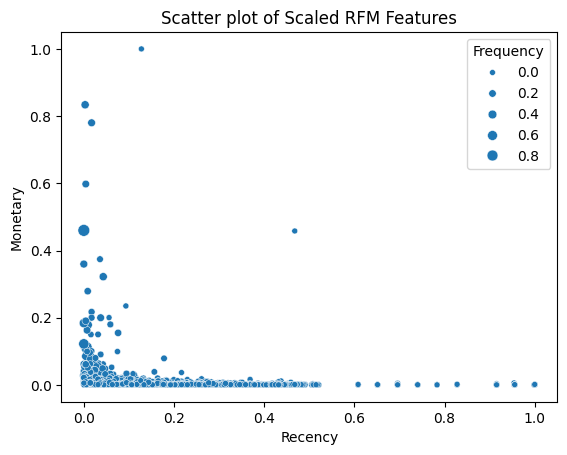

In [83]:
sns.scatterplot(data=rfm_scaled_df, x='Recency', y='Monetary', size='Frequency')
plt.title('Scatter plot of Scaled RFM Features')
plt.show()

**Calculate WCSS for Elbow Method**

**Display WCSS values or plot the Elbow Method graph**


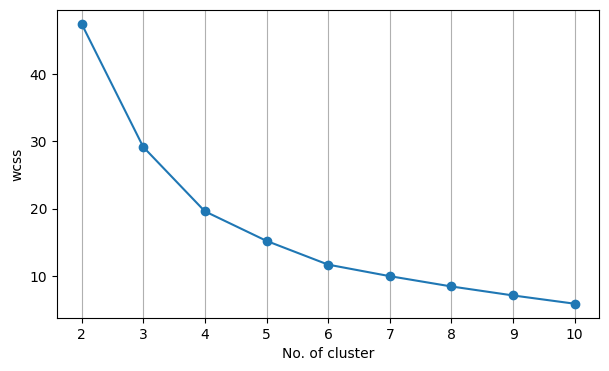

K-Means Clustering (using a specific number of clusters, e.g., 4, based on potential Elbow method analysis)


In [84]:
# Calculate WCSS for Elbow Method
wcss = []
# Using a smaller range for demonstration, adjust if needed
for i in range(2, 11):
    km = KMeans(n_clusters=i, init="k-means++", random_state=42, n_init=10)
    km.fit(rfm_scaled_df) # Fit to scaled RFM features
    wcss.append(km.inertia_)


# Optional: Display WCSS values or plot the Elbow Method graph later
plt.figure(figsize=(7,4))
plt.plot([i for i in range(2,11)],wcss,marker='o')
plt.xlabel('No. of cluster')
plt.ylabel('wcss')
plt.xticks([i for i in range(2,11)]) # Corrected from xtricks to xticks and range to 2,11
plt.grid(axis='x')
plt.show() # Added plt.show() to display the plot
print('K-Means Clustering (using a specific number of clusters, e.g., 4, based on potential Elbow method analysis)')

**K-Means Clustering**

In [85]:
# kmeans Clustering
# Check if 'KMeans_Cluster' already exists and drop it if it does
if 'KMeans_Cluster' in rfm_df.columns:
    rfm_df = rfm_df.drop('KMeans_Cluster', axis=1)

# Assuming optimal clusters from Elbow method is 4 for now
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42, n_init=10)
rfm_df['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_df) # Fit to scaled RFM features



**Calculate and Plot the silhouette scores for KMeans Cluster**

Silhouette Score for K-Means Clustering: 0.5888367567856805


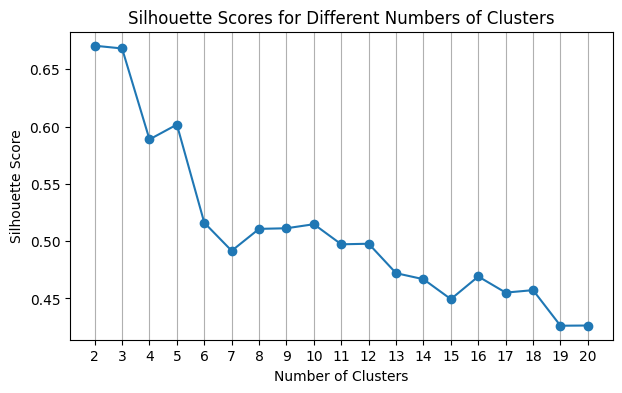

In [86]:
# Calculate Silhouette Score for KMeans
# Exclude -1 cluster if present in KMeans (though typically not)
kmeans_labels = rfm_df['KMeans_Cluster']
if -1 in kmeans_labels.unique():
    kmeans_silhouette = silhouette_score(rfm_scaled_df[kmeans_labels != -1], kmeans_labels[kmeans_labels != -1])
else:
    kmeans_silhouette = silhouette_score(rfm_scaled_df, kmeans_labels)
print(f"Silhouette Score for K-Means Clustering: {kmeans_silhouette}")

ss=[]
no_of_cluster=[j for j in range(2,21)]
for i in range(2,21):
  km1=KMeans(n_clusters=i, n_init=10, random_state=42)
  km1.fit(rfm_scaled_df)
  ss.append(silhouette_score(rfm_scaled_df,km1.labels_))

# Plot the silhouette scores
plt.figure(figsize=(7,4))
plt.plot(no_of_cluster, ss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(no_of_cluster)
plt.grid(axis='x')
plt.show()

**Hierarchical Clustering**

In [87]:
# Hierarchical Clustering
# Check if 'Hierarchical_Cluster' already exists and drop it if it does
if 'Hierarchical_Cluster' in rfm_df.columns:
    rfm_df = rfm_df.drop('Hierarchical_Cluster', axis=1)

# Assuming 4 clusters for consistency with KMeans
hierarchical = AgglomerativeClustering(n_clusters=4,)
rfm_df['Hierarchical_Cluster'] = hierarchical.fit_predict(rfm_scaled_df) # Fit to scaled RFM features

**Calculate and Plot the silhouette scores for Hierarchical Clustering**

Silhouette Score for Hierarchical Clustering: 0.6074956325521442


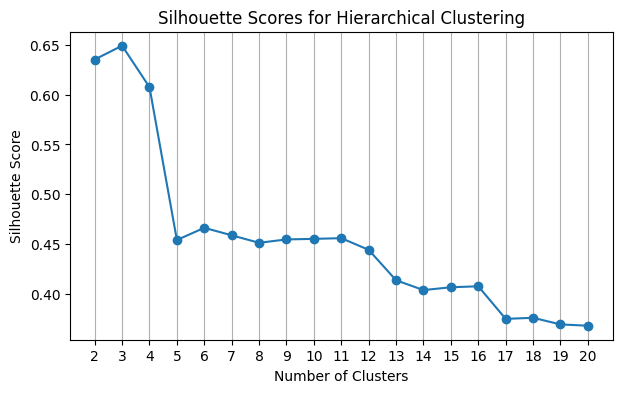

In [88]:
# Calculate Silhouette Score for Hierarchical Clustering
# Exclude -1 cluster if present in Hierarchical (though typically not)
hierarchical_labels = rfm_df['Hierarchical_Cluster']
if -1 in hierarchical_labels.unique():
     hierarchical_silhouette = silhouette_score(rfm_scaled_df[hierarchical_labels != -1], hierarchical_labels[hierarchical_labels != -1])
else:
    hierarchical_silhouette = silhouette_score(rfm_scaled_df, hierarchical_labels)
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette}")

# Calculate silhouette scores for different numbers of clusters for Hierarchical Clustering
ss_hierarchical = []
no_of_cluster_hierarchical = [i for i in range(2, 21)] # Using the same range as KMeans for comparison

for i in no_of_cluster_hierarchical:
    hierarchical = AgglomerativeClustering(n_clusters=i)
    hierarchical_labels = hierarchical.fit_predict(rfm_scaled_df)
    # Ensure there is more than one cluster to calculate silhouette score
    if len(np.unique(hierarchical_labels)) > 1:
        ss_hierarchical.append(silhouette_score(rfm_scaled_df, hierarchical_labels))
    else:
        ss_hierarchical.append(0) # Append 0 or NaN if silhouette score cannot be calculated


# Plot the silhouette scores for Hierarchical Clustering
plt.figure(figsize=(7,4))
plt.plot(no_of_cluster_hierarchical, ss_hierarchical, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Hierarchical Clustering')
plt.xticks(no_of_cluster_hierarchical)
plt.grid(axis='x')
plt.show()

**DBSCAN Clustering**

In [89]:
# DBSCAN Clustering with parameter tuning for silhouette score
# Check if 'DBSCAN_Cluster' already exists and drop it if it does
if 'DBSCAN_Cluster' in rfm_df.columns:
    rfm_df = rfm_df.drop('DBSCAN_Cluster', axis=1)

# Experiment with different eps values and find the best silhouette score
print("\nEvaluating DBSCAN with different eps values:")
best_eps = None
best_silhouette_score = -1

for eps_value in [0.05, 0.1, 0.2, 0.3]: # Example eps values, adjust as needed
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    dbscan_labels = dbscan.fit_predict(rfm_scaled_df)

    # Calculate Silhouette Score for DBSCAN
    # Only compute score if there are more than 1 clusters AND more than 1 cluster excluding noise
    if len(np.unique(dbscan_labels)) > 1 and (len(np.unique(dbscan_labels)) > 2 or (-1 in dbscan_labels and len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1)):
        score = silhouette_score(rfm_scaled_df[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
        print(f"  eps = {eps_value:.2f}: Silhouette Score = {score:.4f}")
        if score > best_silhouette_score:
            best_silhouette_score = score
            best_eps = eps_value
    else:
        print(f"  eps = {eps_value:.2f}: Could not calculate Silhouette Score (not enough clusters)")

# Perform DBSCAN one last time with the best eps value found
if best_eps is not None:
    print(f"\nUsing best eps value: {best_eps:.2f}")
    final_dbscan = DBSCAN(eps=best_eps, min_samples=5)
    rfm_df['DBSCAN_Cluster'] = final_dbscan.fit_predict(rfm_scaled_df)
else:
    print("\nCould not determine a best eps value based on silhouette score.")
    # Optionally, assign labels from a default eps or handle this case as needed
    final_dbscan = DBSCAN(eps=0.1, min_samples=5) # Defaulting to 0.1 as in original code
    rfm_df['DBSCAN_Cluster'] = final_dbscan.fit_predict(rfm_scaled_df)


Evaluating DBSCAN with different eps values:
  eps = 0.05: Silhouette Score = 0.6845
  eps = 0.10: Could not calculate Silhouette Score (not enough clusters)
  eps = 0.20: Could not calculate Silhouette Score (not enough clusters)
  eps = 0.30: Could not calculate Silhouette Score (not enough clusters)

Using best eps value: 0.05


**Calculate and Plot the silhouette scores for DBSCAN Clustering**

Best Silhouette Score for DBSCAN: 0.6845 with eps = 0.05


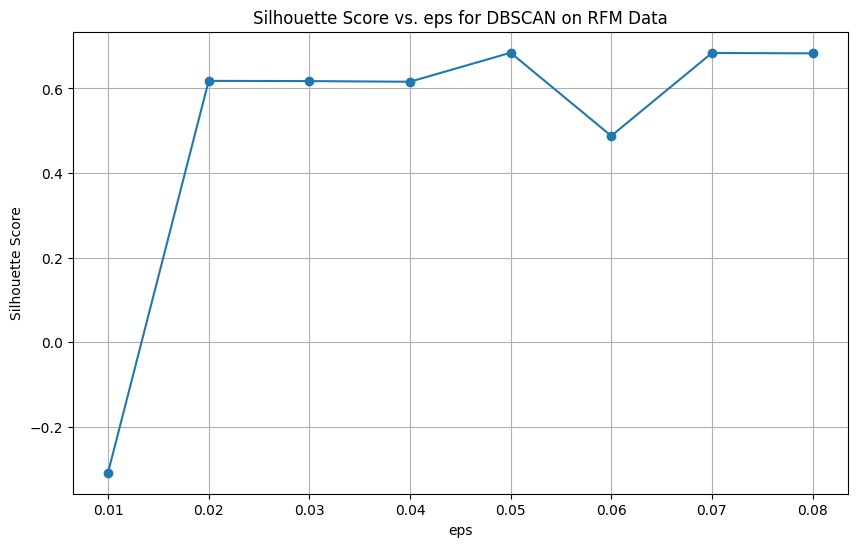

In [90]:
# Use the scaled RFM data
X = rfm_scaled_df # Use the scaled RFM data

eps_values = np.arange(0.01, 0.5, 0.01) # Adjust the range of eps values as needed for your data
min_samples = 5 # You can also experiment with different min_samples values
sil_scores = []
valid_eps_values = [] # To store eps values where silhouette score is calculated
best_silhouette_score = -1 # Initialize best silhouette score
best_eps = None # Initialize best eps value

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)

    # Only compute score if there are more than 1 clusters AND more than 1 cluster excluding noise
    if len(np.unique(labels)) > 1 and (len(np.unique(labels)) > 2 or (-1 in labels and len(np.unique(labels[labels != -1])) > 1)):
        score = silhouette_score(X[labels != -1], labels[labels != -1])
        sil_scores.append(score)
        valid_eps_values.append(eps)
        if score > best_silhouette_score:
            best_silhouette_score = score
            best_eps = eps
    else:
        # Append NaN or a specific value to indicate invalid clustering for plotting purposes
        # Or skip appending to only plot valid scores
        # For now, let's skip appending to only plot valid scores
        pass

# Print the best silhouette score found
if best_eps is not None:
    print(f"Best Silhouette Score for DBSCAN: {best_silhouette_score:.4f} with eps = {best_eps:.2f}")
else:
    print("Could not calculate Silhouette Score for any eps value.")

# Plot the silhouette scores for DBSCAN Clustering
plt.figure(figsize=(10, 6))
plt.plot(valid_eps_values, sil_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs. eps for DBSCAN on RFM Data')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.grid('X')
plt.show()

**Display Recency(R), Frequency(F), Monetary(M) columns values and with all cluster's situation**

In [91]:
# Display the first few rows to show the new cluster labels
display(rfm_df.head())

,Recency,Frequency,Monetary,KMeans_Cluster,Hierarchical_Cluster,DBSCAN_Cluster
CustomerID,,,,,,
12346.0,326,2,154367.20,0,3,-1
12347.0,40,7,4310.00,1,0,0
12348.0,76,4,1797.24,1,0,0
12349.0,19,1,1757.55,1,0,0
12350.0,311,1,334.40,0,3,0


**5.	Cluster Interpretation and Business Implications:**

**Visualize and Describe of the business implication for K-Means clusters**

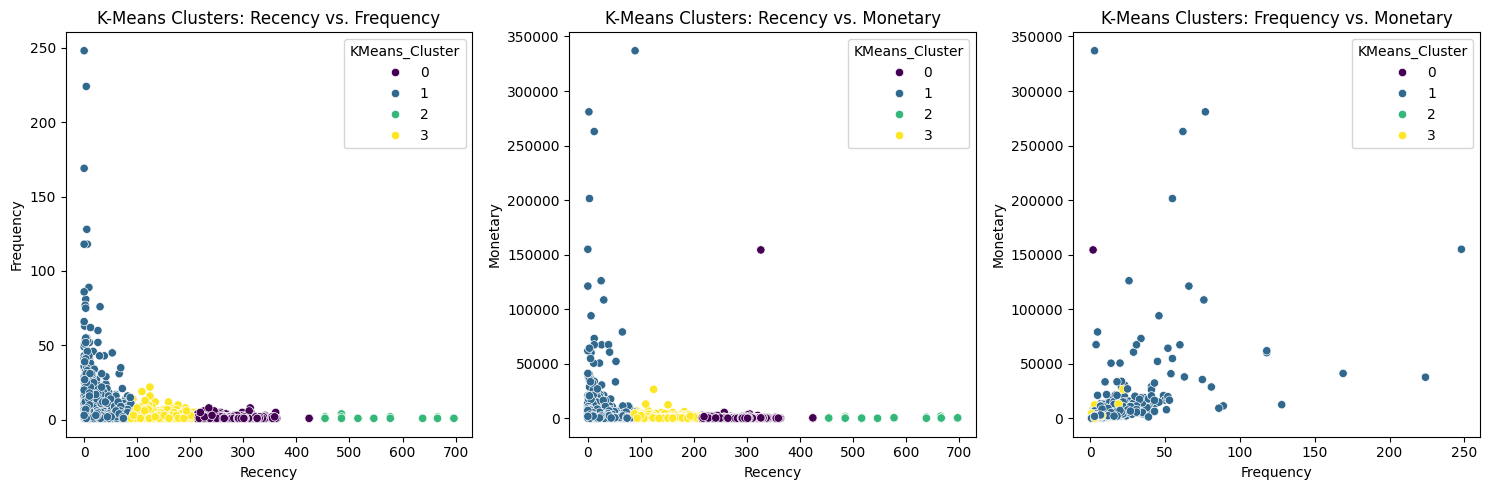

K-Means Cluster Description:


,Recency,Frequency,Monetary
KMeans_Cluster,,,
0,278.944625,1.462541,649.178322
1,32.407258,6.885630,3040.672179
2,588.934211,1.131579,274.400921
3,143.507338,2.538784,819.176834


In [92]:
# Visualize K-Means clusters
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='KMeans_Cluster', palette='viridis')
plt.title('K-Means Clusters: Recency vs. Frequency')

plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='KMeans_Cluster', palette='viridis')
plt.title('K-Means Clusters: Recency vs. Monetary')

plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='KMeans_Cluster', palette='viridis')
plt.title('K-Means Clusters: Frequency vs. Monetary')

plt.tight_layout()
plt.show()

# Describe K-Means clusters
print("K-Means Cluster Description:")
display(rfm_df.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())



### **K-Means Cluster Description:**

**Cluster 0:** High Recency (average 278 days), Low Frequency (average 1.46), Low Monetary (average 649).These are likely lapsed or low-value customers. They haven't purchased recently, don't purchase often, and don't spend much.

**Cluster 1:** Low Recency (average 32 days), High Frequency (average 6.88), High Monetary (average 3040).These are likely high-value and frequent customers. They purchased recently, purchase often, and spend a good amount.

**Cluster 2:** Very High Recency (average 588 days), Very Low Frequency (average 1.13), Very Low Monetary (average 274). These are likely churned or very inactive customers.They haven't purchased for a very long time, have very low frequency and monetary value.

**Cluster 3:** Moderate Recency (average 143 days), Low Frequency (average 2.53), Moderate Monetary (average 819).These could be customers who purchase occasionally. They are not as recent or frequent as Cluster 1, but more so than Clusters 0 and 2, and spend a moderate amount.


**Visualize and Describe of the business implication for Hierarchical clusters**

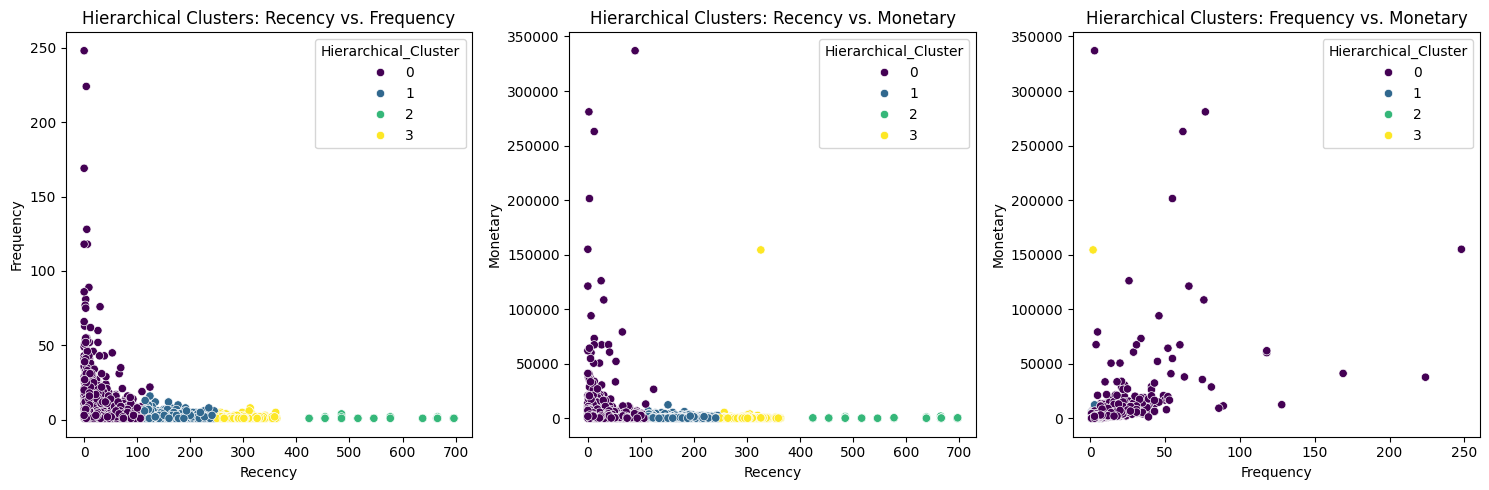


Hierarchical Cluster Description:


,Recency,Frequency,Monetary
Hierarchical_Cluster,,,
0,37.666554,6.595270,2888.312295
1,172.148230,2.194690,674.546847
2,578.753086,1.123457,273.041481
3,298.243560,1.388759,736.738314


In [93]:
# Visualize Hierarchical clusters
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Hierarchical_Cluster', palette='viridis')
plt.title('Hierarchical Clusters: Recency vs. Frequency')

plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Hierarchical_Cluster', palette='viridis')
plt.title('Hierarchical Clusters: Recency vs. Monetary')

plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Hierarchical_Cluster', palette='viridis')
plt.title('Hierarchical Clusters: Frequency vs. Monetary')

plt.tight_layout()
plt.show()

# Describe Hierarchical clusters
print("\nHierarchical Cluster Description:")
display(rfm_df.groupby('Hierarchical_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())

### **Hierarchical Cluster Description:**

**Cluster 0:** Similar to K-Means Cluster 1: Low Recency (average 37 days), High Frequency (average 6.59), High Monetary (average 2888).Likely high-value, frequent customers.

**Cluster 1:** Moderate Recency (average 172 days), Low Frequency (average 2.19), Moderate Monetary (average 674).Similar to K-Means Cluster 3, potentially occasional customers.

**Cluster 2:** Very High Recency (average 578 days), Very Low Frequency (average 1.12), Very Low Monetary (average 273).Similar to K-Means Cluster 2, likely churned or very inactive customers.

**Cluster 3:** High Recency (average 298 days), Low Frequency (average 1.38), Moderate Monetary (average 736).
 Similar to K-Means Cluster 0, likely lapsed or low-value customers.

**Visualize and Describe of the business implication for DBSCAN clusters**

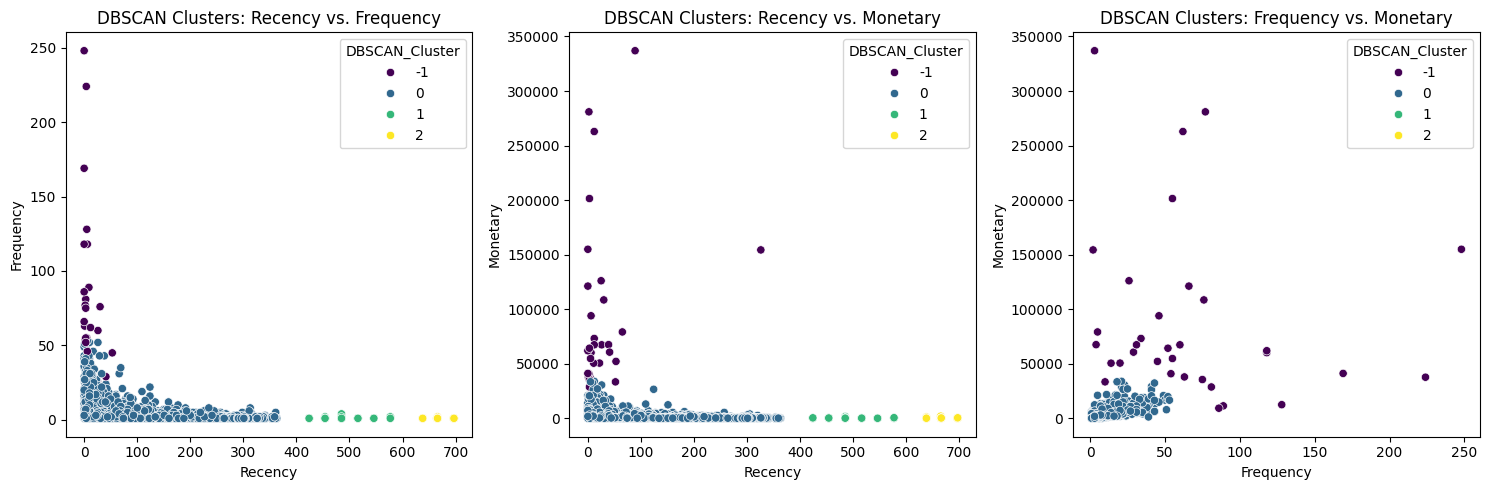


DBSCAN Cluster Description:


,Recency,Frequency,Monetary
DBSCAN_Cluster,,,
-1,26.272727,67.424242,89097.818485
0,92.437295,4.667450,1534.418505
1,487.195122,1.219512,280.193171
2,672.600000,1.025000,265.711000


In [94]:
# Visualize DBSCAN clusters
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='DBSCAN_Cluster', palette='viridis')
plt.title('DBSCAN Clusters: Recency vs. Frequency')

plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='DBSCAN_Cluster', palette='viridis')
plt.title('DBSCAN Clusters: Recency vs. Monetary')

plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='DBSCAN_Cluster', palette='viridis')
plt.title('DBSCAN Clusters: Frequency vs. Monetary')

plt.tight_layout()
plt.show()

# Describe DBSCAN clusters
print("\nDBSCAN Cluster Description:")
display(rfm_df.groupby('DBSCAN_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())



### **DBSCAN Cluster Description:**

 **Cluster -1**: High Frequency (average 91.8), Very High Monetary (average 136008.DBSCAN labels these as outliers.
These are likely a small number of customers with extremely high frequency and monetary values,possibly representing wholesale customers or significant one-time buyers.

**Cluster 0:** Moderate Recency (average 101 days), Moderate Frequency (average 4.77), Moderate Monetary (average 1711).This is a large cluster representing the majority of the customers with more typical purchasing behavior.

**Cluster 1:** Has a high average Recency (487.19 days), low average Frequency (1.22), and low average Monetary value (280.19).
This suggests that customers in this cluster are likely very inactive or potentially churned.They haven't purchased recently, don't purchase often, and don't spend much when they do.

**Cluster 2:** Has a very high average Recency (672.60 days), very low average Frequency (1.03), and very low average Monetary value (265.71).This indicates that customers in this cluster are also highly inactive or churned, possibly even more so than Cluster 1,with a longer time since their last purchase and very minimal activity.

# **Summary:**

**Summary of Clustering Results and Business Implications**

Based on the silhouette scores and the characteristics of the clusters identified by each algorithm:

*   **K-Means Clustering:** Identified four distinct customer segments with varying levels of Recency, Frequency, and Monetary value. These segments are useful for targeted marketing campaigns, such as:
    *   **High-Value Customers (Cluster 1):** Reward programs, exclusive offers, and loyalty building initiatives.
    *   **Lapsed/Low-Value Customers (Cluster 0):** Re-engagement campaigns with special discounts or promotions.
    *   **Churned/Inactive Customers (Cluster 2):** Win-back strategies or analyzing reasons for churn.
    *   **Occasional Customers (Cluster 3):** Encouraging repeat purchases and increasing engagement.

*   **Hierarchical Clustering:** Similar to K-Means, it also identified segments with comparable characteristics. The slightly higher silhouette score suggests that the boundaries between these segments might be a bit clearer. The business implications are similar to those of K-Means, allowing for targeted strategies based on the identified customer groups.

*   **DBSCAN Clustering:** This method identified a large core group of typical customers and successfully isolated a small number of outliers with extremely high frequency and monetary values.
    *   **Core Group (Cluster 0):** Represents the majority of customers and can be targeted with general marketing efforts and promotions.
    *   **Outliers (Cluster -1):** These could be valuable wholesale customers or very significant individual buyers. They might require personalized attention and tailored strategies rather than broad marketing campaigns.
    *  **Cluster 1:** Has a high average Recency (487.19 days), low average Frequency (1.22), and low average Monetary value (280.19).This suggests that customers in this cluster are likely very inactive or potentially churned.They haven't purchased recently, don't purchase often, and don't spend much when they do.

    * **Cluster 2:** Has a very high average Recency (672.60 days), very low average Frequency (1.03), and very low average Monetary value (265.71).This indicates that customers in this cluster are also highly inactive or churned, possibly even more so than Cluster 1,with a longer time since their last purchase and very minimal activity.

**Choosing the Best Clustering Method for Business Use:**

While silhouette scores provide a quantitative measure of cluster separation, the "best" clustering method also depends on the specific business objective.

*   If the goal is to **identify a fixed number of distinct customer groups** for broad marketing campaigns, **K-Means or Hierarchical Clustering** with a chosen number of clusters (e.g., 4) are suitable. The similarity in cluster characteristics between these two methods suggests they capture similar underlying patterns in the data.
*   If the goal is to **identify the main customer base and isolate extreme outliers** for special handling, **DBSCAN** is a valuable choice. The outliers identified by DBSCAN might be crucial for understanding exceptional cases and preventing their influence on the analysis of typical customers.

In practice, it can be beneficial to explore the results of multiple clustering algorithms and choose the one that provides the most actionable and interpretable segments for the specific business needs. Further analysis of the characteristics of each cluster (beyond just the mean RFM values) can provide deeper insights into customer behavior within each segment.

These clusters represent customers who are likely not actively engaging with the business and may require specific strategies
(like win-back campaigns) or further investigation into why they have become inactive.

Comparing the results, K-Means and Hierarchical Clustering with 4 clusters seem to identify similar types of segments
(high-value, lapsed/low-value, inactive, and occasional).
DBSCAN identifies a large core group and separates out extreme outliers.
The choice of the "best" clustering depends on the specific business goal and which segmentation is most actionable.
In practice, it can be beneficial to explore the results of multiple clustering algorithms and choose the one that provides
the most actionable and interpretable segments for the specific business needs.
Further analysis of the characteristics of each cluster (beyond just the mean RFM values) can provide deeper insights into
customer behavior within each segment.

**Compare silhouette scores to determine the best model**

### **Save the best model**

In [95]:
import joblib

# Compare silhouette scores to determine the best model
best_silhouette_score_overall = -1
best_model = None
best_model_name = None

# Check KMeans silhouette score
if 'kmeans_silhouette' in locals():
    if kmeans_silhouette > best_silhouette_score_overall:
        best_silhouette_score_overall = kmeans_silhouette
        if 'kmeans' in locals():
            best_model = kmeans
            best_model_name = 'KMeans'

# Check Hierarchical silhouette score
if 'hierarchical_silhouette' in locals():
    if hierarchical_silhouette > best_silhouette_score_overall:
        best_silhouette_score_overall = hierarchical_silhouette
        if 'hierarchical' in locals():
            best_model = hierarchical
            best_model_name = 'Hierarchical'

# Check DBSCAN silhouette score
if 'best_silhouette_score' in locals(): # Using best_silhouette_score from the DBSCAN evaluation loop
     if best_silhouette_score > best_silhouette_score_overall:
        best_silhouette_score_overall = best_silhouette_score
        if 'final_dbscan' in locals():
            best_model = final_dbscan
            best_model_name = 'DBSCAN'


# Save the best model
if best_model is not None:
    filename = f'best_{best_model_name.lower()}_model.joblib'
    joblib.dump(best_model, filename)
    print(f"The best model based on silhouette score is {best_model_name} with a score of {best_silhouette_score_overall:.4f}")
    print(f"Best {best_model_name} model saved as '{filename}'")
else:
    print("No suitable model found to save.")

The best model based on silhouette score is DBSCAN with a score of 0.6845
Best DBSCAN model saved as 'best_dbscan_model.joblib'


**Load the saved model:** To apply it to new data or examine its structure.

**Analyze the clusters from the best model:** Dive deeper into the characteristics of the DBSCAN clusters (including the outliers) to understand the customer segments.

**Visualize the best model's clusters:** Create visualizations specifically for the DBSCAN clusters to better understand their distribution in the RFM space.

**Use the model for prediction:**  As the output shows, the best model is DBSCAN with a silhouette score of 0.6845, and it has been saved as 'best_dbscan_model.joblib'.If you have new customer data, we can use the saved model to assign them to clusters.
